
--- Generating cylinder mesh: radius=1.0, height=2.0, lc=1.0 ---
Geo file '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_0.geo' created.
Running gmsh to generate mesh '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_0_tet.msh' ...
Info    : Running 'gmsh /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_0.geo -3 -format msh2 -o /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_0_tet.msh' [Gmsh 4.13.1, 1 node, max. 1 thread]
Info    : Started on Wed Jul  9 18:09:01 2025
Info    : Reading '/Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_0.geo'...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 40%] Meshing curve 2 (Line)
Info    : [ 70%] Meshing curve 3 (Circle)
Info    : Done meshing 1D (Wall 0.000793833s, CPU 0.000108s)
Info    : Meshing 2D...
Info    : [  0%] 

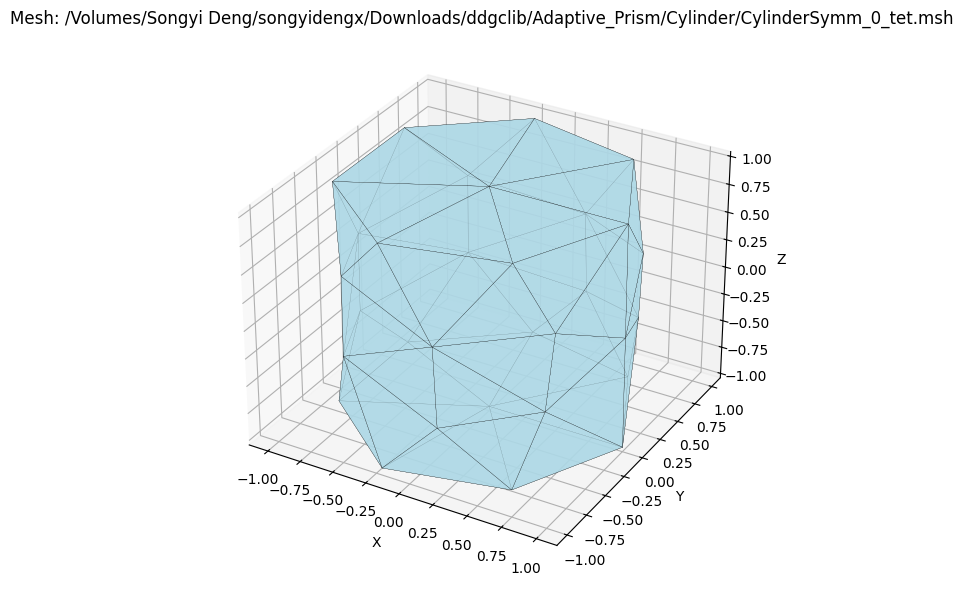

Visualizing: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_1_tet.msh



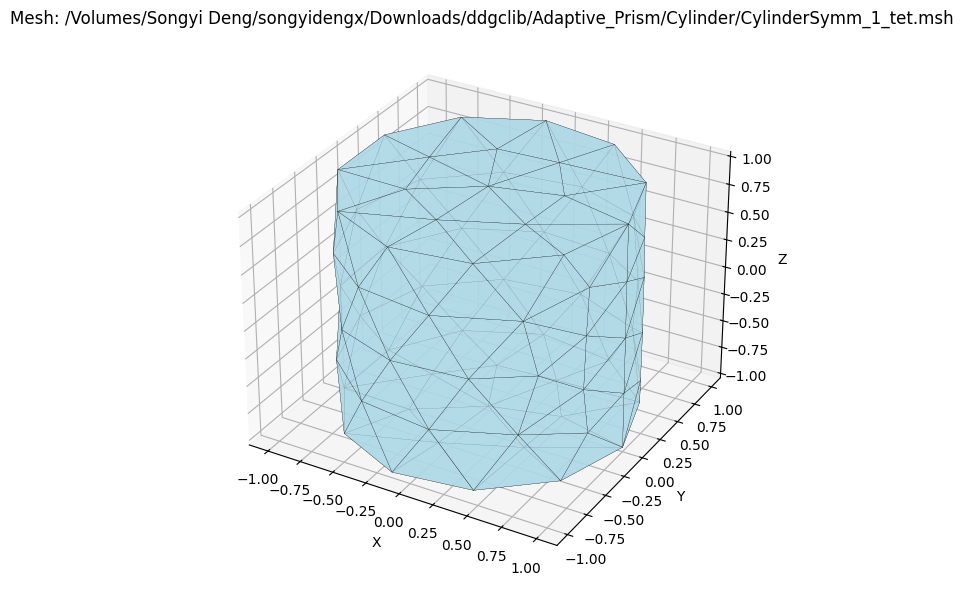

Visualizing: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_2_tet.msh



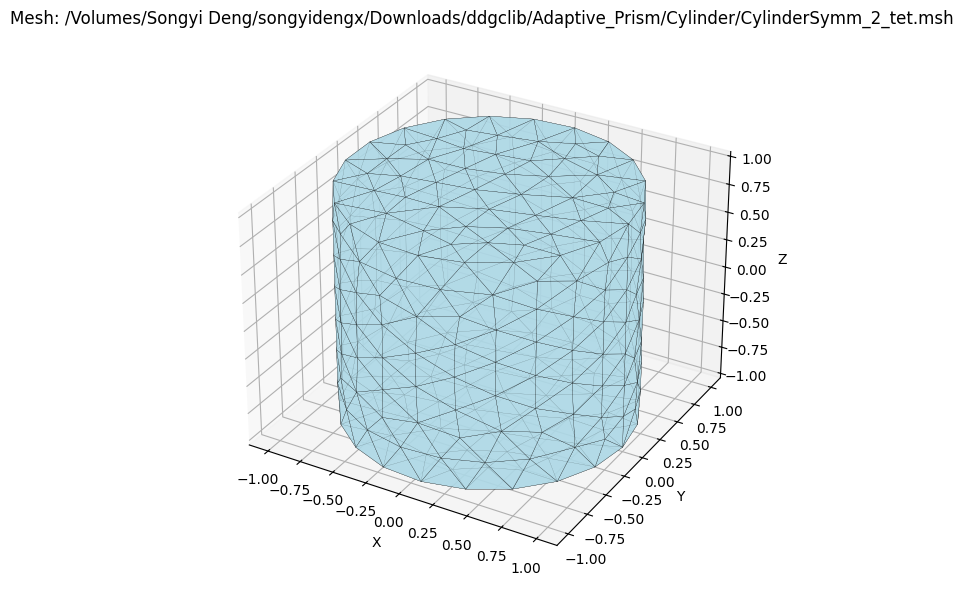

Visualizing: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_3_tet.msh



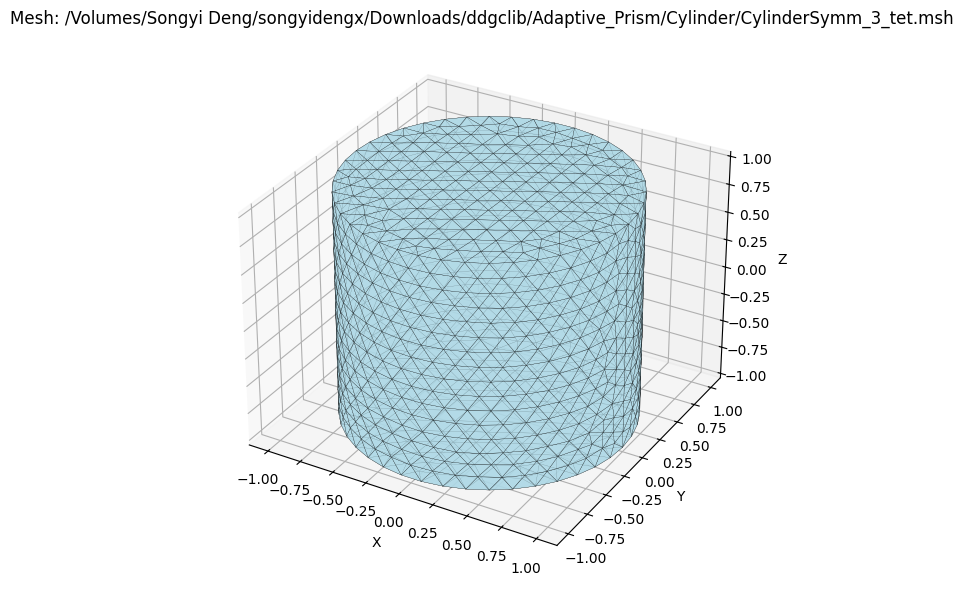

In [2]:
# 1_Geo and Mesh (with light blue surface triangles)

import numpy as np
from _cylinder_volume_pt1_Mesh_Quadrics import generate_meshes

import meshio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

radius = 1.0
height = 2.0

mesh_settings = [
    (1.0, "CylinderSymm_0"),
    (0.6, "CylinderSymm_1"),
    (0.3, "CylinderSymm_2"),
    (0.15, "CylinderSymm_3"),
]

mesh_results = []
for lc, prefix in mesh_settings:
    results = generate_meshes(radius, height, lc, prefix)
    mesh_results.append(results)
    print(f"Generated mesh {results['tet_meshname']} ({results['tet_count']} tets)")

print("All meshes generated.")

# === Visualization of each generated mesh ===
for mesh_info in mesh_results:
    mesh_file = mesh_info['tet_meshname']
    print(f"Visualizing: {mesh_file}")
    mesh = meshio.read(mesh_file)
    points = mesh.points

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Mesh: {mesh_file}")

    # Plot surface triangles in light blue if available
    if 'triangle' in mesh.cells_dict:
        tris = mesh.cells_dict['triangle']
        faces = [points[tri] for tri in tris]
        tri_collection = Poly3DCollection(faces, facecolor='lightblue', edgecolor='k', linewidths=0.15, alpha=0.7)
        ax.add_collection3d(tri_collection)
    else:
        ax.scatter(points[:,0], points[:,1], points[:,2], s=1, alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.auto_scale_xyz([points[:,0].min(), points[:,0].max()],
                      [points[:,1].min(), points[:,1].max()],
                      [points[:,2].min(), points[:,2].max()])
    plt.tight_layout()
    plt.show()


In [11]:
# 2_Volume Computation Benchmark

import pandas as pd
import time
from _volume_pt2_Unify import unify_coeffs
from _volume_pt3_ComputeVolume import compute_volume_error

SUMMARY_CSV = 'volume_error_summary.csv'
summary_rows = []

radius = 1.0
height = 2.0
V_theory = np.pi * radius ** 2 * height

for mesh_info in mesh_results:
    tet_meshname = mesh_info["tet_meshname"]
    quadric_csv = mesh_info["quadric_csv"]
    tet_count = mesh_info["tet_count"]
    
    print(f"Processing mesh: {tet_meshname} with {tet_count} tets.")

    # Unify quadric coefficients if needed
    unified_csv = unify_coeffs(quadric_csv)

    # Time the compute_volume_error call
    t0 = time.time()
    vol_row = compute_volume_error(
        tet_meshname, unified_csv, V_theory, tol=1e-4, max_depth=6
    )
    compute_time = time.time() - t0

    # Build the row in the specified order
    row = {
        'num_tet': vol_row['num_tet'],
        'rel_error_piecewise': vol_row['rel_error_piecewise'],
        'rel_error_patchsum': vol_row['rel_error_patchsum'],
        'V_piecewise': vol_row['V_piecewise'],
        'V_patch_sum': vol_row['V_patch_sum'],
        'num_tris': vol_row['num_tris'],
        'compute_time_sec': compute_time,
        'tet_meshname': tet_meshname,
        'quadric_csv': quadric_csv,
        'unified_csv': unified_csv,
        'tet_count': tet_count,
    }
    summary_rows.append(row)

    # Save all results so far to summary CSV
    columns = ['num_tet', 'rel_error_piecewise', 'rel_error_patchsum', 'V_piecewise', 'V_patch_sum', 
            'num_tris', 'compute_time_sec', 'tet_meshname', 'quadric_csv', 'unified_csv', 'tet_count']
    pd.DataFrame(summary_rows)[columns].to_csv(SUMMARY_CSV, index=False)
    print(f"Saved summary to {SUMMARY_CSV} after {tet_meshname}")

print(f"All results saved to {SUMMARY_CSV}")


Processing mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_0_tet.msh with 60 tets.
All coefficients set to analytic cylinder. Saved as /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_0_fit_tet60_unified.csv



Curved patch sum: 100%|██████████| 58/58 [00:14<00:00,  3.90it/s]

Saved summary to volume_error_summary.csv after /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_0_tet.msh
Processing mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_1_tet.msh with 243 tets.
All coefficients set to analytic cylinder. Saved as /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_1_fit_tet243_unified.csv




Curved patch sum: 100%|██████████| 150/150 [00:36<00:00,  4.16it/s]

Saved summary to volume_error_summary.csv after /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_1_tet.msh
Processing mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_2_tet.msh with 1306 tets.
All coefficients set to analytic cylinder. Saved as /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_2_fit_tet1306_unified.csv




Curved patch sum: 100%|██████████| 548/548 [02:08<00:00,  4.27it/s]


Saved summary to volume_error_summary.csv after /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_2_tet.msh
Processing mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_3_tet.msh with 9041 tets.
All coefficients set to analytic cylinder. Saved as /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_3_fit_tet9041_unified.csv



Curved patch sum: 100%|██████████| 2044/2044 [08:14<00:00,  4.13it/s]

Saved summary to volume_error_summary.csv after /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_3_tet.msh
All results saved to volume_error_summary.csv


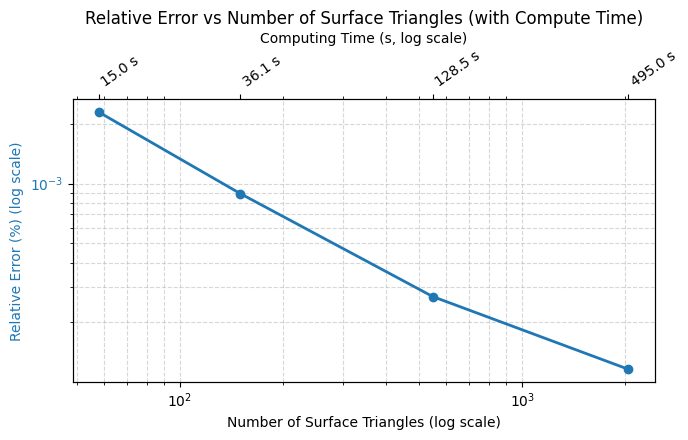

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

csv_file = 'volume_error_summary.csv'
if not os.path.exists(csv_file) or os.stat(csv_file).st_size == 0:
    print(f"{csv_file} does not exist or is empty. Cannot plot.")
else:
    try:
        df = pd.read_csv(csv_file)
    except pd.errors.EmptyDataError:
        print(f"{csv_file} exists but has no columns. Cannot plot.")
    else:
        if df.empty or 'num_tris' not in df or 'rel_error_patchsum' not in df or 'compute_time_sec' not in df:
            print("CSV exists but does not have the expected columns. Cannot plot.")
        else:
            df = df.sort_values('num_tris')
            x = df['num_tris']
            y = df['rel_error_patchsum']
            t = df['compute_time_sec']

            fig, ax1 = plt.subplots(figsize=(7, 4.5))

            color = 'tab:blue'
            ax1.set_xlabel('Number of Surface Triangles (log scale)')
            ax1.set_ylabel('Relative Error (%) (log scale)', color=color)
            ax1.loglog(x, y, marker='o', color=color, linewidth=2)
            ax1.tick_params(axis='y', labelcolor=color)
            ax1.grid(True, which="both", ls='--', alpha=0.5)

            # Top x-axis for computing time, with 's' for seconds
            ax2 = ax1.twiny()
            ax2.set_xscale('log')
            ax2.set_xlim(ax1.get_xlim())
            ax2.set_xticks(x)
            ax2.set_xticklabels(['{:.1f} s'.format(val) for val in t], rotation=35, ha='left')
            ax2.set_xlabel('Computing Time (s, log scale)')

            plt.title('Relative Error vs Number of Surface Triangles (with Compute Time)')
            plt.tight_layout()
            plt.show()


In [4]:
import numpy as np
import pandas as pd
import meshio
import time
from _cylinder_solid_angle_patch import tet_volume, solid_angle_patch, get_surface_triangle_set_from_msh

radius = 1.0
height = 2.0
V_theory = np.pi * radius ** 2 * height
summary_csv = "volume_error_summary_solid_angle.csv"
summary_rows = []

for mesh_info in mesh_results:
    mesh_name = mesh_info["tet_meshname"]
    quadric_csv = mesh_info["quadric_csv"]
    unified_csv = mesh_info.get("unified_csv", "")
    tet_count = mesh_info["tet_count"]

    print(f"Processing mesh: {mesh_name}")
    mesh = meshio.read(mesh_name)
    points = mesh.points

    # Find surface triangles
    surf_faces = []
    for cell_block in mesh.cells:
        if cell_block.type in ("triangle", "triangle6"):
            surf_faces = cell_block.data
            break
    if len(surf_faces) == 0:
        print(f"No triangle faces found in mesh {mesh_name}! Skipping.")
        continue

    # Find tets
    tet_cells = None
    for cell_block in mesh.cells:
        if cell_block.type in ("tetra", "tet"):
            tet_cells = cell_block.data
            break
    if tet_cells is None:
        print(f"No tetrahedra found in mesh {mesh_name}! Skipping.")
        continue

    # Piecewise volume (sum of all tets)
    V_piecewise = 0.0
    for tet in tet_cells:
        pts4 = points[tet]
        V_piecewise += tet_volume(pts4)

    # Solid angle patch sum for all surface triangles
    t0 = time.time()
    V_patchsum_solidangle = 0.0
    for tri in surf_faces:
        A, B, C = points[tri[0]], points[tri[1]], points[tri[2]]
        V_patchsum_solidangle += solid_angle_patch(A, B, C, radius)
    compute_time = time.time() - t0

    rel_error_piecewise = abs(V_piecewise - V_theory) / V_theory * 100
    rel_error_patchsum = abs(V_patchsum_solidangle + V_piecewise - V_theory) / V_theory * 100

    row = {
        'num_tet': len(tet_cells),
        'rel_error_piecewise': rel_error_piecewise,
        'rel_error_patchsum': rel_error_patchsum,
        'V_piecewise': V_piecewise,
        'V_patch_sum': V_patchsum_solidangle,
        'num_tris': len(surf_faces),
        'compute_time_sec': compute_time,
        'tet_meshname': mesh_name,
        'quadric_csv': quadric_csv,
        'unified_csv': unified_csv,
        'tet_count': tet_count,
    }
    summary_rows.append(row)

    print(f"Processed mesh: {mesh_name}")
    print(f"  V_piecewise: {V_piecewise:.8f}")
    print(f"  V_patch_sum (solid angle): {V_patchsum_solidangle:.8f}")
    print(f"  rel_error_patchsum (solid angle): {rel_error_patchsum:.6f}%")
    print(f"  Compute time: {compute_time:.2f} s")

# Save all to CSV
cols = ['num_tet','rel_error_piecewise','rel_error_patchsum','V_piecewise','V_patch_sum',
        'num_tris','compute_time_sec','tet_meshname','quadric_csv','unified_csv','tet_count']
pd.DataFrame(summary_rows)[cols].to_csv(summary_csv, index=False)
print(f"Saved solid angle patch summary to {summary_csv}")


Processing mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_0_tet.msh

Processed mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_0_tet.msh
  V_piecewise: 5.68391731
  V_patch_sum (solid angle): 0.59928660
  rel_error_patchsum (solid angle): 0.000296%
  Compute time: 0.00 s
Processing mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_1_tet.msh

Processed mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_1_tet.msh
  V_piecewise: 6.05096810
  V_patch_sum (solid angle): 0.23221917
  rel_error_patchsum (solid angle): 0.000031%
  Compute time: 0.00 s
Processing mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_2_tet.msh

Processed mesh: /Volumes/Songyi Deng/songyidengx/Downloads/ddgclib/Adaptive_Prism/Cylinder/CylinderSymm_2_tet.msh
  V_piecewise: 6.21532530
  V_patch_sum 

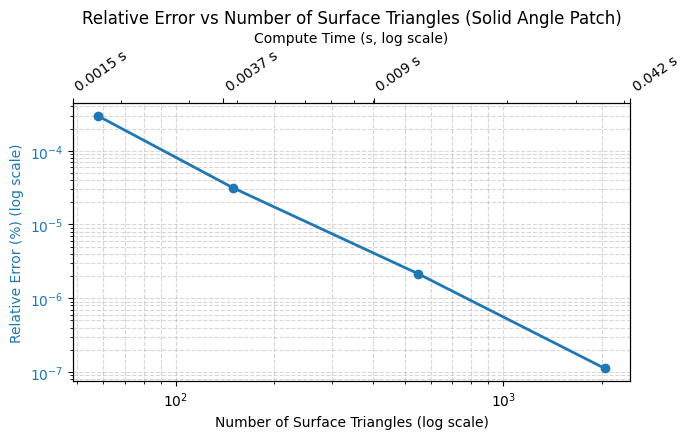

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

csv_file = 'volume_error_summary_solid_angle.csv'
if not os.path.exists(csv_file) or os.stat(csv_file).st_size == 0:
    print(f"{csv_file} does not exist or is empty. Cannot plot.")
else:
    try:
        df = pd.read_csv(csv_file)
    except pd.errors.EmptyDataError:
        print(f"{csv_file} exists but has no columns. Cannot plot.")
    else:
        if df.empty or 'num_tris' not in df or 'rel_error_patchsum' not in df or 'compute_time_sec' not in df:
            print("CSV exists but does not have the expected columns. Cannot plot.")
        else:
            df = df.sort_values('num_tris')
            x = df['num_tris']
            y = df['rel_error_patchsum']
            t = df['compute_time_sec']

            fig, ax1 = plt.subplots(figsize=(7, 4.5))

            color = 'tab:blue'
            ax1.set_xlabel('Number of Surface Triangles (log scale)')
            ax1.set_ylabel('Relative Error (%) (log scale)', color=color)
            ax1.loglog(x, y, marker='o', color=color, linewidth=2)
            ax1.tick_params(axis='y', labelcolor=color)
            ax1.grid(True, which="both", ls='--', alpha=0.5)

            # Top x-axis for compute time: independent (not rescaled to X1)
            ax2 = ax1.twiny()
            # Set ax2's scale and limits to those of compute time
            ax2.set_xscale('log')
            ax2.set_xlim([t.min(), t.max()])
            ax2.set_xlabel('Compute Time (s, log scale)')

            # Optionally: plot the same y values vs compute time on the top axis (invisible, for ticks)
            # We just plot (t, y) but don't display the line.
            ax2.plot(t, y, alpha=0)  # Dummy for axis linking

            # Set ticks at the compute time values
            ax2.set_xticks(t)
            ax2.set_xticklabels(['{:.2g} s'.format(val) for val in t], rotation=35, ha='left')

            plt.title('Relative Error vs Number of Surface Triangles (Solid Angle Patch)')
            plt.tight_layout()
            plt.show()
